<h2> Dieses Notebook führt die Volumenschätzung ausschließlich aus Basis der Tiefenwerte, intrinsischen Matrix und referenz Dimensionen aus, welche direkt aus dem IPhone via Apple SDK gewonnen wurden.

# Import der Libraries

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import open3d as o3d
import cv2
from Functions.processing_depthmap_pc import transform_binary_to_depthmap
from Functions.processing_depthmap_pc import extrude_pcd
from Functions import volume_estimation
from scipy.stats import uniform, randint
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import os
import glob
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import RandomizedSearchCV

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Tiefenkarte lesen und plotten

Einlesen der Binary

In [2]:
binary_url = r"Data\BinaryLidarData\Mango\DepthMap.bin"
depth_map = transform_binary_to_depthmap(binary_url)

Einlesen des RGB image

In [3]:
rgb_url = r"Data\BinaryLidarData\Mango\color_image.jpg"
rgb_im = Image.open(rgb_url)

In [4]:
rgb_height, rgb_width =rgb_im.size
rgb_height

1920

In [5]:
depth_map_for_rgb = depth_map.astype(np.float32)
rgb_o3d_dm = o3d.geometry.Image(depth_map_for_rgb)

Plotten der Tiefenkarte

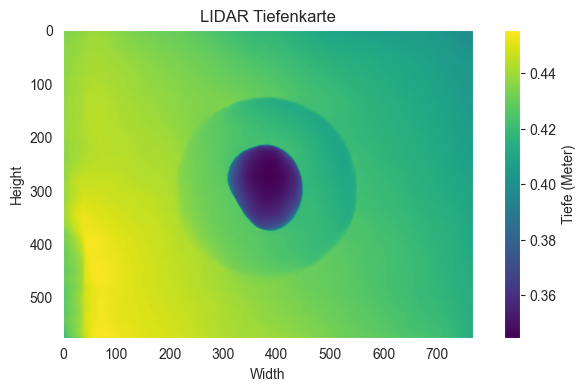

In [6]:
plt.figure(figsize=(8, 4))
plt.imshow(depth_map, cmap = "viridis")
plt.colorbar(label="Tiefe (Meter)")
plt.title("LIDAR Tiefenkarte")
plt.ylabel("Height")
plt.xlabel("Width")
plt.grid(False)
plt.show()

# Rescaling

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [7]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

In [8]:
dm_height, dm_width= depth_map.shape
print(f"height:{dm_height} , width:{dm_width}")

height:576 , width:768


Skalierung des RGB-Bilds, um die Segmentierung korrekt auf die Tiefenkarte anzuwenden

In [9]:
# Bild auf 576x768 skalieren
rgb_im = rgb_im.resize((768, 576), Image.BILINEAR)  # BILINEAR für weiche Skalierung

In [10]:
rgb_im.size

(768, 576)

In [11]:
rgb_array = np.array(rgb_im, dtype=np.uint8)
rgb_o3d = o3d.geometry.Image(rgb_array)

RGBD

In [12]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, rgb_o3d_dm)  # Quelle:https://www.open3d.org/docs/latest/python_api/open3d.geometry.RGBDImage.html und https://stackoverflo.com/questions/63587617/how-to-create-a-rgbd-image-from-numpy-rgb-array-and-depth-array


# Intrinsic camera calibration

intrinsische Matrix

In [13]:
intrinsic_matrix = np.array([
    [2876.100341796875, 0, 2018.2723388671875],
    [0, 2876.100341796875, 1518.2470703125],
    [0, 0, 1]
])

intrinsic = o3d.camera.PinholeCameraIntrinsic(width=dm_width, height=dm_height, fx=intrinsic_matrix[0,0], fy=intrinsic_matrix[1,1], cx=intrinsic_matrix[0,2], cy=intrinsic_matrix[1,2])

print(intrinsic_matrix)


[[2.89220337e+03 0.00000000e+00 2.01657092e+03]
 [0.00000000e+00 2.89220337e+03 1.51767078e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Referenzdimensionen für die Skalierung der intrinsischen Matrix

In [14]:
#OriginalWerte
# ref_height = 4032
# ref_width = 3024

In [15]:
#Diese Werte nutze ich zum testen, da die Tiefekarte gekippt ist, sind auch höhe und breite vertauscht
ref_height = 3024
ref_width = 4032

In [16]:
# sclaingfactor
scale_x = dm_width / ref_width
scale_y = dm_height / ref_height

# scaling
scaled_mtx = intrinsic_matrix.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[550.89587984   0.         384.10874721]
 [  0.         550.89587984 289.08014788]
 [  0.           0.           1.        ]]


scaled intrinsic

In [17]:
fx = scaled_mtx[0, 0]
fy = scaled_mtx[1, 1]
cx = scaled_mtx[0, 2]
cy = scaled_mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width, height=dm_height, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 550.8958798363095, fy: 550.8958798363095, cx: 384.1087472098214, cy: 289.0801478794643


# Segmentierung

## R-CNN laden

In [18]:
# Mask R-CNN Modell mit COCO-Gewichten laden
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)
model.eval()

C:\Users\Diren\Masterarbeit\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Diren\Masterarbeit\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [19]:
# Bild laden
image = rgb_im
image_tensor = F.to_tensor(image).unsqueeze(0)

# Bild durch das Modell laufen lassen
with torch.no_grad():
    prediction = model(image_tensor)

## Best label

In [20]:
best_index = None
best_score = 0.0
best_label = None

# Iteriere durch alle erkannten Objekte
for i, label in enumerate(prediction[0]["labels"]):
    score = prediction[0]["scores"][i].item()
    
    print(f"Objekt {i}: COCO-Klasse {label}, Score: {score:.2f}")

    # Falls Score der höchste ist, speichere das Label
    if score > best_score:
        best_score = score
        best_label = label
        best_index = i  # Speichert auch den Index des besten Objekts

# Ausgabe des besten Labels
if best_label is not None:
    print(f"\nBestes Label: COCO-Klasse {best_label}, Score: {best_score:.2f}")
else:
    print("\nKeine gültige Vorhersage gefunden.")


Objekt 0: COCO-Klasse 53, Score: 0.98
Objekt 1: COCO-Klasse 51, Score: 0.94
Objekt 2: COCO-Klasse 67, Score: 0.91
Objekt 3: COCO-Klasse 47, Score: 0.10
Objekt 4: COCO-Klasse 53, Score: 0.07

Bestes Label: COCO-Klasse 53, Score: 0.98


Visualisierung der verschiedenen Masken

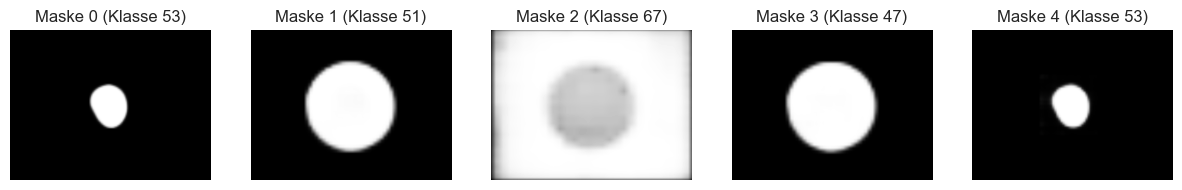

In [21]:
fig, axes = plt.subplots(1, len(prediction[0]["masks"]), figsize=(15, 5))

for i, mask in enumerate(prediction[0]["masks"]):
    mask_np = mask.squeeze().cpu().numpy()
    axes[i].imshow(mask_np, cmap="gray")
    axes[i].set_title(f"Maske {i} (Klasse {prediction[0]['labels'][i].item()})")
    axes[i].axis("off")

plt.show()


## Best mask

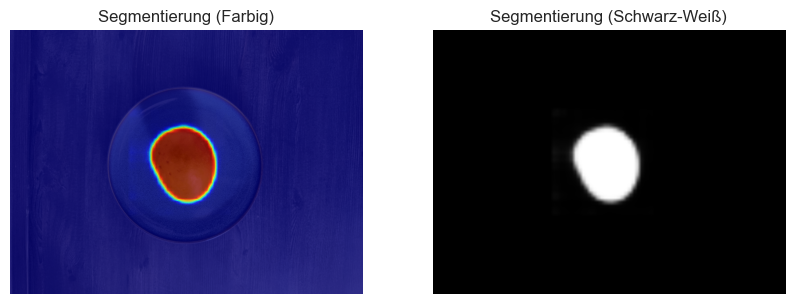

In [22]:

# Erster Plot: Originalbild farbig
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Erste Hälfte des Plots
plt.imshow(image)

for i, mask in enumerate(prediction[0]['masks']):
    if prediction[0]['labels'][i] == best_label: # 51 scheinbar bowl #47 scheinabr teller
        mask_np_best = mask.squeeze().cpu().numpy()
        plt.imshow(mask_np_best, alpha=0.5, cmap="jet")  # Farbliche Überlagerung

plt.axis("off")
plt.title("Segmentierung (Farbig)")

# Zweiter Plot: Maske in Schwarz-Weiß
plt.subplot(1, 2, 2)  # Zweite Hälfte des Plots
plt.imshow(mask_np_best, cmap="gray")
plt.axis("off")
plt.title("Segmentierung (Schwarz-Weiß)")

plt.show()


## Smallest mask

Maskenauswahl anhand von kleinster Fläche

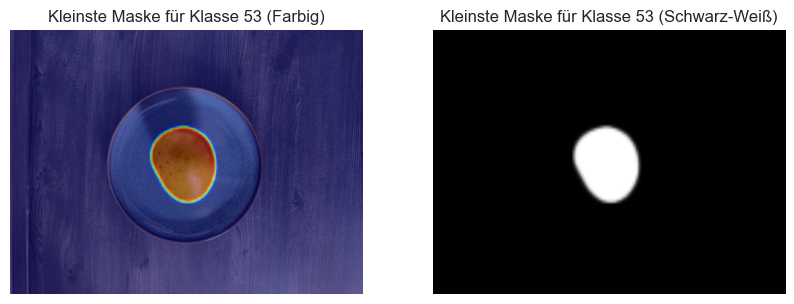

In [23]:
smallest_mask = None
smallest_size = float("inf")  # Startwert: Unendlich groß

for i, mask in enumerate(prediction[0]["masks"]):
    if prediction[0]["labels"][i] == best_label:  # Nur für die gewählte Klasse
        mask_np = mask.squeeze().cpu().numpy()
        mask_size = np.sum(mask_np)  # Anzahl der aktivierten Pixel berechnen

        if mask_size < smallest_size and mask_size > 0:  # Kein leeres Objekt
            smallest_size = mask_size
            smallest_mask = mask_np

if smallest_mask is not None:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.imshow(smallest_mask, alpha=0.5, cmap="jet")
    plt.axis("off")
    plt.title(f"Kleinste Maske für Klasse {best_label} (Farbig)")

    plt.subplot(1, 2, 2)
    plt.imshow(smallest_mask, cmap="gray")
    plt.axis("off")
    plt.title(f"Kleinste Maske für Klasse {best_label} (Schwarz-Weiß)")

    plt.show()
else:
    print(f"Keine gültige Maske für Klasse {best_label} gefunden.")


## Duale Masken

Dieser Abschniit wird nur benötigt, wenn zwie Lebensmittel im Bild vorhanden sind.

In [24]:
combined_mask = mask_np_best  +  smallest_mask

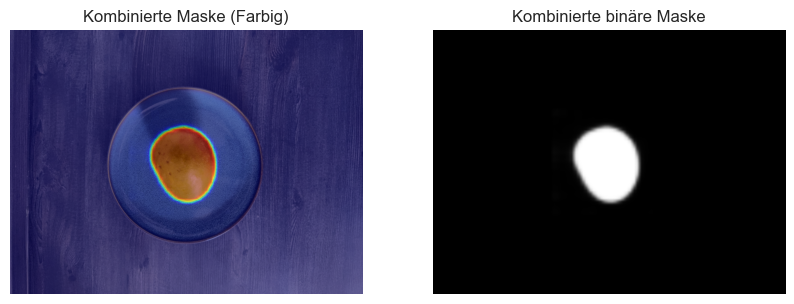

In [25]:
plt.figure(figsize=(10, 5))

# Originalbild mit überlagerter Maske
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.imshow(combined_mask, alpha=0.5, cmap="jet")  # Transparente Überlagerung
plt.axis("off")
plt.title("Kombinierte Maske (Farbig)")

# Graustufenmaske anzeigen
plt.subplot(1, 2, 2)
plt.imshow(combined_mask, cmap="gray")
plt.axis("off")
plt.title("Kombinierte binäre Maske")

plt.show()



## Maske anwenden

In [26]:
import numpy as np
import torch

def split_depth_map(depth_map, mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze().cpu().numpy()

    depth_object = depth_map * mask  # Tiefenwerte innerhalb der Maske
    depth_background = depth_map * (1 - mask)  # Tiefenwerte außerhalb der Maske

    return depth_object, depth_background


# Tiefenkarten berechnen
depth_object, depth_background = split_depth_map(depth_map, smallest_mask)
depth_objects_dual, depth_background_dual = split_depth_map(depth_map, combined_mask)

# Optional: Werte ausgeben
print("Durchschnittliche Tiefe (Objekt):", np.mean(depth_object[depth_object > 0]))
print("Durchschnittliche Tiefe (Hintergrund):", np.mean(depth_background[depth_background > 0]))


Durchschnittliche Tiefe (Objekt): 0.24219757
Durchschnittliche Tiefe (Hintergrund): 0.411268


Filterung von Ausreißern am Rand der Segmentierung

In [27]:
mask_np = (smallest_mask > 0.5).astype(np.uint8)  # Binärmaske erstellen
dual_np = (combined_mask > 0.5).astype(np.uint8)


In [28]:
depth_object = depth_map * mask_np  # Nur Werte in der Maske beibehalten
dual_objects  = depth_map * dual_np

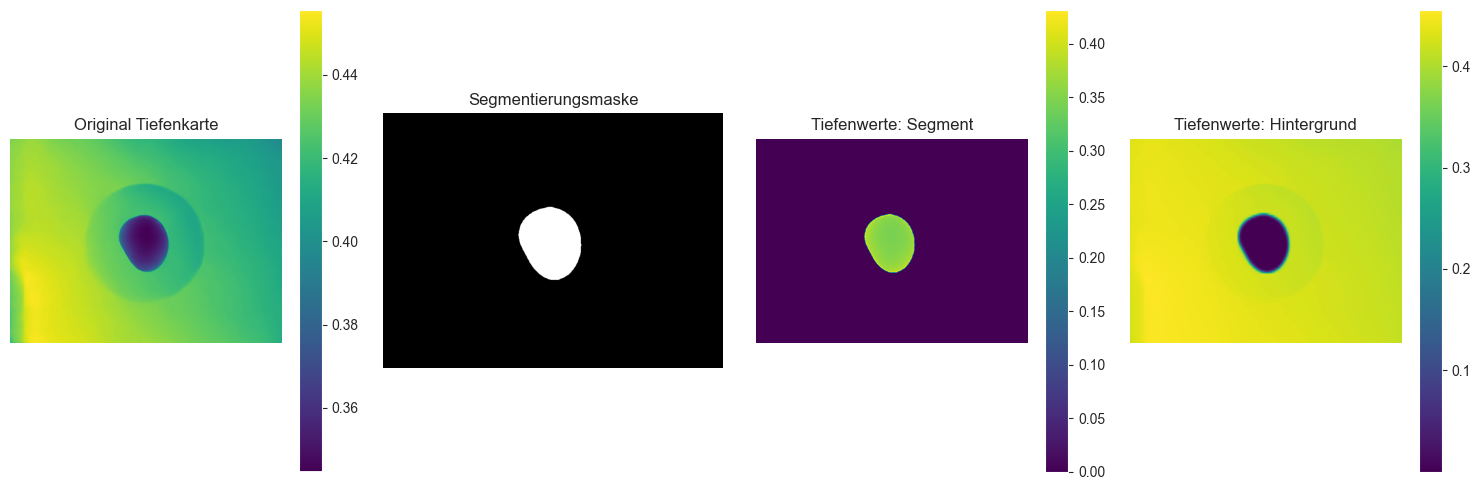

In [29]:
import matplotlib.pyplot as plt

def visualize_depth_maps(depth_map, depth_object, depth_background, mask):
    plt.figure(figsize=(15, 5))
    
    # Binäre Maske
    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title("Segmentierungsmaske")
    
    # Original Tiefenkarte
    plt.subplot(1, 4, 1)
    plt.imshow(depth_map, cmap="viridis")
    plt.colorbar()
    plt.axis("off")
    plt.title("Original Tiefenkarte")
    
    # Tiefenkarte für das Objekt (Foreground)
    plt.subplot(1, 4, 3)
    plt.imshow(depth_object, cmap="viridis")
    plt.colorbar()
    plt.axis("off")
    plt.title("Tiefenwerte: Segment")
    
    # Tiefenkarte für den Hintergrund (Background)
    plt.subplot(1, 4, 4)
    plt.imshow(depth_background, cmap="viridis")
    plt.colorbar()
    plt.axis("off")
    plt.title("Tiefenwerte: Hintergrund")
    
    plt.tight_layout()
    plt.show()

# Visualisierung aufrufen
visualize_depth_maps(depth_map, depth_object, depth_background, mask_np)


(np.float64(-0.5), np.float64(767.5), np.float64(575.5), np.float64(-0.5))

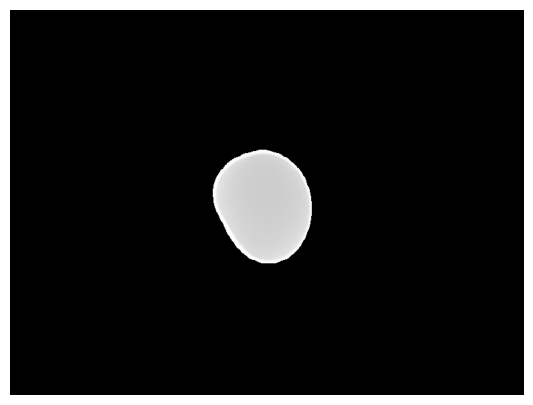

In [30]:
plt.figure(figsize=(15, 5))
plt.imshow(dual_objects, cmap="gray")
plt.axis("off")

# Create point cloud

## Ganze Punktwolke

Open3D Object without metric scaling

In [31]:
depth_data_uint16_Iphone = (depth_map.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

In [32]:
depth_image = o3d.geometry.Image(depth_map.astype(np.float32))

Pointcloud

In [33]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # 
    depth_trunc=2.0,  # Maximal erlaubte Tiefe. 3 Meter reichen für unsere Ansprüche.
    stride=1  # Jeder Pixel wird genutzt bei Stride = 1
)


In [34]:
num_points = len(np.asarray(pcd.points))
print(f"Anzahl der Punkte in der Punktwolke: {num_points}")

Anzahl der Punkte in der Punktwolke: 442368


In [35]:
o3d.visualization.draw_geometries([pcd])

In [36]:
pcd_array = np.asarray(pcd.points, dtype=np.float16)

## RGBD-Punktwolke

In [38]:
rgbd_pc = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic_scaled)
o3d.visualization.draw_geometries([rgbd_pc])

## Maskierte Punktwolke

In [39]:
# Open3D Image erstellen (Nullwerte bleiben, werden aber gefiltert)
depth_image = o3d.geometry.Image(depth_object.astype(np.float32))

# Punktwolke aus der Tiefenkarte erstellen (nur segmentierte Punkte)
pcd_object = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # Falls Tiefendaten in Metern vorliegen
    depth_trunc=3.0,  # Maximal erlaubte Tiefe (ggf. anpassen)
    stride=1
)

In [40]:
pcd_object_array = np.asarray(pcd_object.points, dtype=np.float16)

In [41]:
# Visualisierung (Nur segmentierte Punkte)
o3d.visualization.draw_geometries([pcd_object])

## Estimating normals

In [42]:
# nn_distance = np.mean(pcd_object.compute_nearest_neighbor_distance())

# print(nn_distance)

In [43]:
# radius_normals = nn_distance * 4
# 
# pcd_object.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)
# 
# pcd_object.paint_uniform_color([0.6, 0.6, 0.6])
# o3d.visualization.draw_geometries([pcd])

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [44]:
# pcd_center = pcd_object.get_center()
# pcd_object.translate(pcd_center)

# Punktwolke ausfüllen

Das Problem beim Extrahieren des jeweiligen Lebensmittels ist, dass, da nicht alle Punkte in der Tiefenkarte sichtbar sind, diese Punkte fehlen und das Objekt an Höhe verliert, sobald man den RANSAC-Algorithmus ausführt.
Um die korrekte Höhe beizubehalten, kann man das Lebensmittel bis zur ebenen Fläche erweitern und somit vervollständigen.  

In [45]:
pcd_object_comp = extrude_pcd(pcd_object)

# Clean Point Cloud

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

Beste Parameter ermitteln

In [46]:
# Parameter-Suchbereich definieren
random_params_sor = {
    "nb_neighbors": randint(50, 200),  # Werte zwischen 50 und 200
    "std_ratio": uniform(0.8, 2.0)    # Werte zwischen 0.8 und 2.8
}

# Evaluierungsfunktion für SOR
def evaluate_sor(nb_neighbors, std_ratio, pointcloud):
    pcd_copy = pointcloud  # Kopie der Punktwolke, um Originaldaten zu erhalten
    cl, ind = pcd_copy.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    return len(ind)  # Maximierung der Anzahl der verbleibenden Punkte


# Randomized Search
n_trials = 30  # Anzahl der getesteten Parameterkombinationen
best_score_plane = 0
best_params_plane = None

Beste Parameter für Object

In [47]:
best_score_object = 0
best_params_object = None

for _ in range(n_trials):
    params = {key: dist.rvs() for key, dist in random_params_sor.items()}
    score = evaluate_sor(**params, pointcloud=pcd_object_comp)  # SOR für Object

    if score > best_score_object:
        best_score_object = score
        best_params_object = params
        
# Parameter als Variablen speichern
nb_neighbors = best_params_object["nb_neighbors"]
std_ratio = best_params_object["std_ratio"]

print("Beste Parameter SOR:", best_params_object)

Beste Parameter SOR: {'nb_neighbors': 125, 'std_ratio': np.float64(2.5097655834754162)}


Function to visualize clean pointcloud and the removed outliers

In [48]:
# Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html
# Verbesserte Laufzeit der vorherigen Funktion

def display_outliers_fast(cloud, ind):
    """ Visualisiert die entfernten Punkte (Outlier) und die verbleibenden Punkte (Inlier) schneller mit NumPy. """
    
    if len(ind) == 0:
        print("Keine Outlier gefunden!")
        return

    points = np.asarray(cloud.points)  # Punktwolke als NumPy-Array
    outlier_mask = np.ones(len(points), dtype=bool)  # Alle Punkte als Outlier markieren
    outlier_mask[ind] = False  # Inlier entfernen → übrig bleiben nur Outlier

    # Neue Punktwolke für Outlier erstellen
    outlier_cloud = o3d.geometry.PointCloud()
    outlier_cloud.points = o3d.utility.Vector3dVector(points[outlier_mask])
    outlier_cloud.paint_uniform_color([1, 0, 0])  # Rot für Outlier

    # Neue Punktwolke für Inlier erstellen
    inlier_cloud = o3d.geometry.PointCloud()
    inlier_cloud.points = o3d.utility.Vector3dVector(points[ind])
    inlier_cloud.paint_uniform_color([0, 1, 0])  # Grün für Inlier

    print(f"Anzahl der Inlier: {len(ind)}")
    print(f"Anzahl der Outlier: {np.sum(outlier_mask)}")

    # Schnellere Visualisierung mit Inlier und Outlier
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

## Clean Object

Removing the outliers from the object

In [49]:
cl, ind = pcd_object_comp.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)

Displaying inliers and outliers

In [50]:
display_outliers_fast(pcd_object_comp, ind)

Anzahl der Inlier: 817670
Anzahl der Outlier: 22135


We will use this PC from now on as Plane

In [51]:
pcd_object_comp = cl
o3d.visualization.draw_geometries([pcd_object_comp])

Punkte generieren Quelle: https://stackoverflow.com/questions/65774814/adding-new-points-to-point-cloud-in-real-time-open3d

# Zusammenfassung der Punktwolke

## Ausdehnung des Objekts

In [52]:
# pcd_object_comp = o3d.io.read_point_cloud(r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Punktwolken\Karotte.ply")


In [53]:
bounds = pcd_object_comp.get_max_bound() - pcd_object_comp.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.3f}, y={bounds[1]:.3f}, z={bounds[2]:.3f}")

Ausdehnung der Punktwolke: x=0.096, y=0.108, z=0.085


# Volumenberechnung

## Voxelization

In [54]:
voxel_volumen = volume_estimation.compute_voxel_volume(pcd_object_comp,0.00111)

Geschätztes Volumen der Punktwolke: 510.31 ml


Sehr wichtig!: Wenn wir statt einfach nur die border zu erweitern und mit der ursprünglichen PCD des Objekts verbinden, die ursprüngliche PCD (ist ja eine Hülle) erweitern und so ein ausgefülltes Objekt erhalten und dieses dann nutzen, um mit Voxelization das Volumen zu erhalten, dann ist das Ergebnis viel besser. Das 

## Convex Hull

In [126]:
ch_volumen =  volume_estimation.compute_convex_hull_volume(pcd_object_comp)

Geschätztes Volumen der konvexen Hülle: 230.47 ml


## Bounding Box

In [ ]:
obb_volumen = volume_estimation.compute_oriented_bounding_box_volume(pcd_object_comp)

## Alpha shapes

In [ ]:
alpha_volumen = volume_estimation.compute_alpha_shape_volume(pcd_object_comp, 0.04)

In [ ]:
V_est = {
    "CH" : ch_volumen,
    "OBB" : obb_volumen,
    "AS" : alpha_volumen,
    "Voxel" : voxel_volumen
}

# Umwandlung in Python-Floats
clean_data = {k: float(v) for k, v in V_est.items()}

print(clean_data)

## Get best voxelsize and alpha shape

Bester Wert für Voxelsize

In [ ]:
def compute_volume(point_cloud, voxel_size):
    """Voxelisiert die Punktwolke und berechnet das Volumen."""
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(point_cloud, voxel_size=voxel_size)
    voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3) * 1_000_000  # Volumen in cm³
    return voxel_volumen

# Ordner mit den .ply-Dateien
ply_folder = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Punktwolken" # Hier den Pfad zu deinen Dateien anpassen
ply_files = glob.glob(os.path.join(ply_folder, "*.ply"))

# Voxelgrößen definieren
voxel_sizes = np.linspace(0.0005, 0.002, 20)  # 0.5 mm bis 2 mm

# Matplotlib-Plot vorbereiten
plt.figure(figsize=(10, 7))

# Durch alle .ply-Dateien iterieren
for ply_file in ply_files:
    # Punktwolke laden
    pcd = o3d.io.read_point_cloud(ply_file)
    
    # Datei-Name extrahieren für den Plot
    filename = os.path.basename(ply_file)
    
    # Volumen für verschiedene Voxelgrößen berechnen
    volumes = [compute_volume(pcd, vs) for vs in voxel_sizes]
    
    # Graph in das gleiche Diagramm zeichnen
    plt.plot(voxel_sizes * 100, volumes, marker='o', linestyle='-', label=filename)

# Achsenbeschriftung und Legende
plt.xlabel("Voxelgröße (cm)")
plt.ylabel("Volumen (cm³)")
plt.title("Volumen als Funktion der Voxelgröße für verschiedene Punktwolken")
plt.legend()
plt.grid(True)

# Diagramm anzeigen
plt.show()


Bester Wert für alpha shape

In [ ]:
def compute_alpha_shape_volume(pcd, alpha, visualize=False):
    # Normalenberechnung
    nn_distance = np.mean(pcd.compute_nearest_neighbor_distance())
    radius_normals = nn_distance * 4

    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16),
                         fast_normal_computation=True)
    pcd.paint_uniform_color([0.6, 0.6, 0.6])  # Einheitliches Grau

    print(f"Erstelle Alpha Shape mit alpha={alpha:.3f}...")
    alpha_shape = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
    alpha_shape.compute_vertex_normals()

    # Volumenberechnung mit Tetrahedral Decomposition
    def compute_mesh_volume(mesh):
        """ Berechnet das Volumen eines Meshs basierend auf Tetrahedral Decomposition. """
        vertices = np.asarray(mesh.vertices)
        triangles = np.asarray(mesh.triangles)

        volume = 0.0
        for tri in triangles:
            v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]
            tetra_volume = np.dot(v0, np.cross(v1, v2)) / 6.0  # Volumen eines Tetraeders
            volume += tetra_volume

        return abs(volume)

    alpha_volume_cm3 = compute_mesh_volume(alpha_shape) * 1_000_000  # Umrechnung in cm³
    print(f"Volumen: {alpha_volume_cm3:.2f} cm³")

    # Visualisierung (optional)
    if visualize:
        o3d.visualization.draw_geometries([alpha_shape], mesh_show_back_face=True, window_name="Alpha Shape")

    return alpha_volume_cm3

# Ordner mit den .ply-Dateien
ply_folder = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Punktwolken"  # Pfad zu den Punktwolken anpassen
ply_files = glob.glob(os.path.join(ply_folder, "*.ply"))

# Alpha-Werte definieren (je kleiner, desto feiner die Struktur)
alpha_values = np.linspace(0.01, 0.1, 20)  # Alpha-Werte von 0.01 bis 0.1

# Matplotlib-Plot vorbereiten
plt.figure(figsize=(10, 7))

# Durch alle .ply-Dateien iterieren
for ply_file in ply_files:
    # Punktwolke laden
    pcd = o3d.io.read_point_cloud(ply_file)
    
    # Datei-Name extrahieren für den Plot
    filename = os.path.basename(ply_file)
    
    # Volumen für verschiedene Alpha-Werte berechnen
    volumes = [compute_alpha_shape_volume(pcd, alpha, visualize=False) for alpha in alpha_values]
    
    # Graph in das gleiche Diagramm zeichnen
    plt.plot(alpha_values, volumes, marker='o', linestyle='-', label=filename)

# Achsenbeschriftung und Legende
plt.xlabel("Alpha-Wert")
plt.ylabel("Volumen (cm³)")
plt.title("Volumen als Funktion des Alpha-Werts für verschiedene Punktwolken")
plt.legend()
plt.grid(True)

# Diagramm anzeigen
plt.show()


# Volumenschätzung mehrerer Objekte

## Gemeinsame Punktwolke

In [ ]:
# Open3D Image erstellen (Nullwerte bleiben, werden aber gefiltert)
depth_image = o3d.geometry.Image(dual_objects.astype(np.float32))

# Punktwolke aus der Tiefenkarte erstellen (nur segmentierte Punkte)
pcd_object_dual = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # Falls Tiefendaten in Metern vorliegen
    depth_trunc=3.0,  # Maximal erlaubte Tiefe (ggf. anpassen)
    stride=1
)

In [ ]:
pcd_object_dual_array = np.asarray(dual_objects.points, dtype=np.float16)

In [ ]:
# Visualisierung (Nur segmentierte Punkte)
o3d.visualization.draw_geometries([pcd_object_dual])

## DBSCAN-Clustering

In [ ]:
# DBSCAN-Clustering
eps = 0.02  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(pcd_object_dual.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# Farbkodierung für Cluster (außer -1)
unique_labels = np.unique(labels)
colors = np.zeros((len(labels), 3))

# Unterschiedliche Farben für Cluster
colormap = plt.get_cmap("tab20")

for i, label in enumerate(unique_labels):
    if label == -1:
        colors[labels == label] = [0, 0, 0]  # Rauschen schwarz
    else:
        colors[labels == label] = colormap(i / num_clusters)[:3]  # Normierte Farbe

# Farben auf die Punktwolke anwenden
pcd_object_dual.colors = o3d.utility.Vector3dVector(colors)

# Visualisierung der Cluster
o3d.visualization.draw_geometries([pcd_object_dual], window_name="DBSCAN Cluster Visualisierung")


In [ ]:
clusters = {}

for cluster_id in np.unique(labels):
    if cluster_id == -1:
        print(f"Rauschen: {np.sum(labels == cluster_id)} Punkte")
        continue

    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_pcd = pcd_object_dual.select_by_index(cluster_indices)
    
    clusters[cluster_id] = cluster_pcd

In [ ]:
cluster_0_pcd = clusters.get(0, None)  # Cluster 0
cluster_1_pcd = clusters.get(1, None)  # Cluster 1

# Falls vorhanden, separate Visualisierung
if cluster_0_pcd:
    o3d.visualization.draw_geometries([cluster_0_pcd], window_name="Cluster 0")

if cluster_1_pcd:
    o3d.visualization.draw_geometries([cluster_1_pcd], window_name="Cluster 1")

## Ausfüllen beider Objekte

This code extends all the points of the object and thus creates a dense object. 

In [ ]:
cluster_0_pcd = extrude_pcd(cluster_0_pcd)
cluster_1_pcd = extrude_pcd(cluster_1_pcd)

In [ ]:
o3d.visualization.draw_geometries([cluster_1_pcd])

## SOR

In [ ]:
cl, ind = cluster_0_pcd.remove_statistical_outlier(nb_neighbors=143, std_ratio=2.5313231811681884)
cluster_0_pcd = cl

cl, ind = cluster_1_pcd.remove_statistical_outlier(nb_neighbors=143, std_ratio=2.5313231811681884)
cluster_1_pcd = cl

In [ ]:
o3d.visualization.draw_geometries([cluster_1_pcd])

## Volumen

In [ ]:
volume_estimation.compute_voxel_volume(cluster_0_pcd,0.0011)

#  Test

## PC speichern

In [ ]:
o3d.io.write_point_cloud(r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Punktwolken\Birne.ply", pcd_object_comp)

In [173]:
pcd_object_array[:,2].max()

np.float16(0.343)

## Reis pc filtern

In [195]:
rice_filter = pcd_object_array[pcd_object_array[:,2]<0.32] 

In [196]:
 # Neue Punkte zur Open3D Punktwolke hinzufügen
new_points = np.array(rice_filter)  # Am Ende in ein numpy-Array umwandeln

# Punktwolke der neuen Punkte visualisieren
pcd_comp_clust = o3d.geometry.PointCloud()
pcd_comp_clust.points = o3d.utility.Vector3dVector(new_points)

In [197]:
cl, ind = pcd_comp_clust.remove_statistical_outlier(nb_neighbors=143, std_ratio=2.5313231811681884)
pcd_comp_clust = cl

o3d.visualization.draw_geometries([pcd_comp_clust])


In [200]:
# DBSCAN-Clustering
eps = 0.02  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(pcd_comp_clust.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# Farbkodierung für Cluster (außer -1)
unique_labels = np.unique(labels)
colors = np.zeros((len(labels), 3))  # Standard: schwarz (Rauschen)

# Nutze unterschiedliche Farben für Cluster
colormap = plt.get_cmap("tab20")  # Alternativ: "viridis", "rainbow", etc.

for i, label in enumerate(unique_labels):
    if label == -1:
        colors[labels == label] = [0, 0, 0]  # Rauschen schwarz
    else:
        colors[labels == label] = colormap(i / num_clusters)[:3]  # Normierte Farbe

# Farben auf die Punktwolke anwenden
pcd_comp_clust.colors = o3d.utility.Vector3dVector(colors)

# Visualisierung der Cluster
o3d.visualization.draw_geometries([pcd_comp_clust], window_name="DBSCAN Cluster Visualisierung")


Anzahl der Cluster: 2


In [202]:
clusters = {}

for cluster_id in np.unique(labels):
    if cluster_id == -1:
        print(f"Rauschen: {np.sum(labels == cluster_id)} Punkte")
        continue

    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_pcd = pcd_comp_clust.select_by_index(cluster_indices)
    
    clusters[cluster_id] = cluster_pcd

In [206]:
cluster_0_pcd = clusters.get(0, None)  # Cluster 0
cluster_1_pcd = clusters.get(1, None)  # Cluster 1

# Falls vorhanden, separate Visualisierung
if cluster_0_pcd:
    o3d.visualization.draw_geometries([cluster_0_pcd], window_name="Cluster 0")

if cluster_1_pcd:
    o3d.visualization.draw_geometries([cluster_1_pcd], window_name="Cluster 1")

In [207]:
cluster_1_pcd = extrude_pcd(cluster_1_pcd)

In [209]:
volume_estimation.compute_alpha_shape_volume(cluster_1_pcd,alpha=0.11)

[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh

np.float64(92.84680653591411)